In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import os
import random
import pickle
import numpy as np

In [2]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import math
import cv2
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from sklearn.metrics import average_precision_score

from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.objectives import categorical_crossentropy

from keras.models import Model
from keras.utils import generic_utils
from keras.engine import Layer, InputSpec
from keras import initializers, regularizers

/home/mirandalv/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mirandalv/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mirandalv/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mirandalv/anaconda3/lib/python3.6/site-packages/tensorflow/python/f

In [3]:
base_path = os.path.abspath(".")
config_output_filename = os.path.join(base_path, 'config.pickle')
record_path = os.path.join(base_path, 'record_path.csv')

In [4]:
df_pickle = pd.read_pickle(config_output_filename)

In [5]:
objects = []
with (open(config_output_filename, "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break

In [6]:
objects[0].use_horizontal_flips

True

In [7]:
df_pickle.model_path

'model_frcnn_64_resnet50.hdf5'

In [8]:
with open(config_output_filename, 'rb') as f_in:
	C = pickle.load(f_in)

# turn off any data augmentation at test time
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

In [ ]:
# Load the records
record_df = pd.read_csv(record_path)

r_epochs = len(record_df)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r')
plt.title('mean_overlapping_bboxes')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r')
plt.title('class_acc')

plt.show()

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r')
plt.title('loss_rpn_regr')
plt.show()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
plt.title('loss_class_cls')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r')
plt.title('loss_class_regr')
plt.show()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
plt.title('total_loss')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['elapsed_time'], 'r')
plt.title('elapsed_time')

plt.show()

In [9]:
ROOT_DIR = os.path.abspath(".")
img_folder = r"/home/mirandalv/Documents/github/geo_AnimalDetection/dataset/processing_small/clipped"

In [10]:
test_df = pd.read_csv(os.path.join(ROOT_DIR, "bounding_box_coordinates.csv"))
test_df['name'] = test_df.apply(lambda x: x['img_name'].split('/')[-1], axis=1)
test_df['img_path'] = test_df.apply(lambda x: os.path.join(img_folder, x['name']), axis=1)
test_df['image_name'] = test_df['name']

In [11]:
test_truth = pd.read_csv('/home/mirandalv/Documents/github/geo_AnimalDetection/dataset/processing_small/test_annotation.csv')

In [12]:
img_count = test_df['name'].unique()

In [13]:
test_truth

,image_name,image_path,label,xmax,xmin,ymax,ymin,id
0,419.tif,/home/cdsw/geo_Animal/geo_AnimalDetection/data...,bird,52,11,43,20,419
1,499.tif,/home/cdsw/geo_Animal/geo_AnimalDetection/data...,bird,54,11,43,19,499
2,499.tif,/home/cdsw/geo_Animal/geo_AnimalDetection/data...,bird,76,31,62,33,499
3,320.tif,/home/cdsw/geo_Animal/geo_AnimalDetection/data...,bird,53,9,50,15,320
4,135.tif,/home/cdsw/geo_Animal/geo_AnimalDetection/data...,bird,53,10,43,20,135
...,...,...,...,...,...,...,...,...
525,216.tif,/home/cdsw/geo_Animal/geo_AnimalDetection/data...,bird,48,13,46,17,216
526,330.tif,/home/cdsw/geo_Animal/geo_AnimalDetection/data...,bird,24,0,11,0,330
527,330.tif,/home/cdsw/geo_Animal/geo_AnimalDetection/data...,bird,51,13,49,16,330
528,308.tif,/home/cdsw/geo_Animal/geo_AnimalDetection/data...,bird,50,13,44,20,308


In [14]:
test_df

,img_name,x1,y1,x2,y2,name,img_path,image_name
0,/home/cdsw/geo_Animal/geo_AnimalDetection/data...,16,16,48,48,114.tif,/home/mirandalv/Documents/github/geo_AnimalDet...,114.tif
1,/home/cdsw/geo_Animal/geo_AnimalDetection/data...,16,16,48,48,430.tif,/home/mirandalv/Documents/github/geo_AnimalDet...,430.tif
2,/home/cdsw/geo_Animal/geo_AnimalDetection/data...,16,16,48,48,411.tif,/home/mirandalv/Documents/github/geo_AnimalDet...,411.tif
3,/home/cdsw/geo_Animal/geo_AnimalDetection/data...,16,16,48,48,476.tif,/home/mirandalv/Documents/github/geo_AnimalDet...,476.tif
4,/home/cdsw/geo_Animal/geo_AnimalDetection/data...,16,16,48,48,391.tif,/home/mirandalv/Documents/github/geo_AnimalDet...,391.tif
...,...,...,...,...,...,...,...,...
439,/home/cdsw/geo_Animal/geo_AnimalDetection/data...,0,0,16,16,149.tif,/home/mirandalv/Documents/github/geo_AnimalDet...,149.tif
440,/home/cdsw/geo_Animal/geo_AnimalDetection/data...,16,16,64,48,492.tif,/home/mirandalv/Documents/github/geo_AnimalDet...,492.tif
441,/home/cdsw/geo_Animal/geo_AnimalDetection/data...,16,16,48,48,289.tif,/home/mirandalv/Documents/github/geo_AnimalDet...,289.tif
442,/home/cdsw/geo_Animal/geo_AnimalDetection/data...,16,16,48,48,406.tif,/home/mirandalv/Documents/github/geo_AnimalDet...,406.tif


In [15]:
def plot_bbox_plt(img_name):
    
    img_url = test_df.loc[test_df["name"]==img_name]['img_path'].values[0]
    
    fig = plt.figure()

    #add axes to the image
    ax = fig.add_axes([0,0,1,1])

    # read and plot the image
    image = plt.imread(img_url)
    plt.imshow(image)

    # iterating over the image for different objects
    for _,row in test_df[test_df.name == img_name].iterrows():
        
        """
        xmin = row.miny
        xmax = row.maxy
        ymin = row.maxx
        ymax = row.minx
        """
        
        xmin = row.x1
        xmax = row.x2
        ymin = row.y1
        ymax = row.y2

        
        width = xmax - xmin
        height = ymax - ymin
    
        # assign different color to different classes of objects
        edgecolor = 'r'
        a = 5
        b = 5
        ax.annotate('bird', xy=(xmax-a,ymin+b))
        
        
        # add bounding boxes to the image
        rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')

        ax.add_patch(rect)

In [16]:
def plot_bbox_truth_plt(img_name):
    
    img_url = test_df.loc[test_df["name"]==img_name]['img_path'].values[0]
    
    fig = plt.figure()

    #add axes to the image
    ax = fig.add_axes([0,0,1,1])

    # read and plot the image
    image = plt.imread(img_url)
    plt.imshow(image)

    # iterating over the image for different objects
    for _,row in test_df[test_df.name == img_name].iterrows():
        
        """
        xmin = row.miny
        xmax = row.maxy
        ymin = row.maxx
        ymax = row.minx
        """
        xmin = row.x1
        xmax = row.x2
        ymin = row.y1
        ymax = row.y2

        
        width = xmax - xmin
        height = ymax - ymin
    
        # assign different color to different classes of objects
        edgecolor = 'r'
        a = 5
        b = 5
        ax.annotate('bird', xy=(xmax-a,ymin+b))
        
        
        # add bounding boxes to the image
        rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
        ax.add_patch(rect)
    
    
#     for _,row in test_truth[test_truth.image_name == img_name].iterrows():
        
#         """
#         xmin = row.miny
#         xmax = row.maxy
#         ymin = row.maxx
#         ymax = row.minx
#         """
        
#         xmin = row.xmin
#         xmax = row.xmax
#         ymin = row.ymin
#         ymax = row.ymax

        
#         width = xmax - xmin
#         height = ymax - ymin
    
#         # assign different color to different classes of objects
#         edgecolor = 'g'
#         a = 5
#         b = 5
#         ax.annotate('bird', xy=(xmax-a,ymin+b))
        
        
#         # add bounding boxes to the image
#         rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
        
#         ax.add_patch(rect)
    

In [17]:
img_names = test_df["name"].value_counts().tail(50).index.values

In [18]:
img_names = test_df["name"].value_counts().index.values

In [19]:
img_names

array(['211.tif', '423.tif', '237.tif', '65.tif', '39.tif', '281.tif',
       '238.tif', '426.tif', '78.tif', '112.tif', '68.tif', '460.tif',
       '381.tif', '144.tif', '332.tif', '108.tif', '283.tif', '325.tif',
       '262.tif', '285.tif', '202.tif', '408.tif', '256.tif', '420.tif',
       '119.tif', '105.tif', '504.tif', '268.tif', '57.tif', '388.tif',
       '440.tif', '149.tif', '270.tif', '36.tif', '164.tif', '274.tif',
       '182.tif', '224.tif', '239.tif', '387.tif', '220.tif', '498.tif',
       '177.tif', '416.tif', '507.tif', '76.tif', '508.tif', '315.tif',
       '118.tif', '330.tif', '421.tif', '16.tif', '317.tif', '293.tif',
       '428.tif', '493.tif', '443.tif', '21.tif', '525.tif', '163.tif',
       '547.tif', '259.tif', '53.tif', '267.tif', '31.tif', '455.tif',
       '70.tif', '22.tif', '61.tif', '429.tif', '209.tif', '145.tif',
       '3.tif', '41.tif', '130.tif', '20.tif', '495.tif', '56.tif',
       '200.tif', '277.tif', '380.tif', '309.tif', '223.tif', '140.tif

211.tif
423.tif
237.tif
65.tif
39.tif
281.tif
238.tif
426.tif
78.tif
112.tif
68.tif
460.tif
381.tif
144.tif
332.tif
108.tif
283.tif
325.tif
262.tif
285.tif


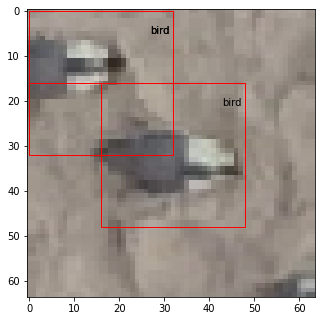

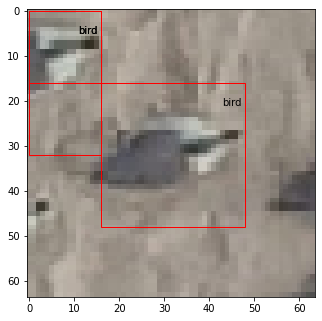

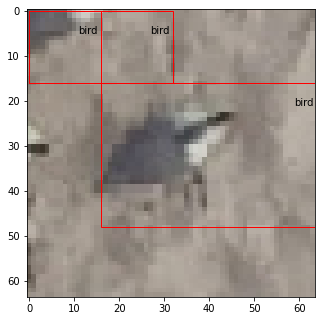

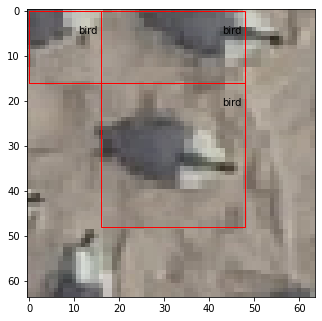

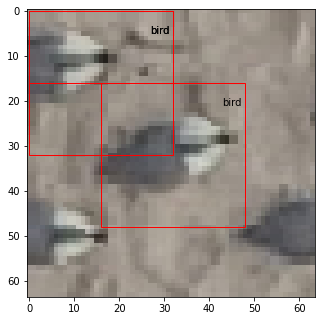

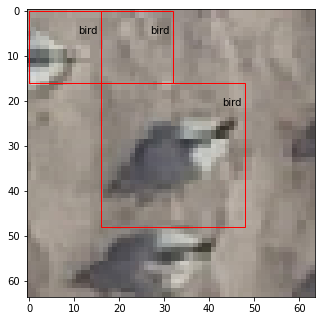

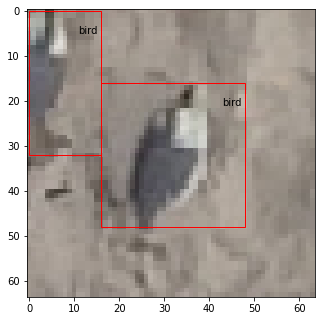

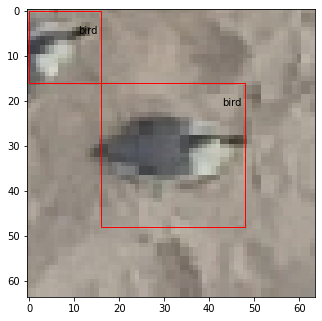

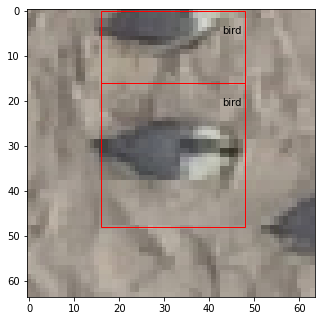

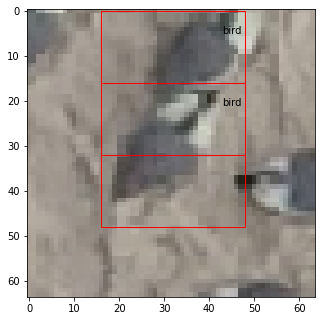

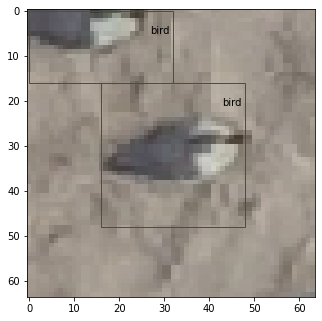

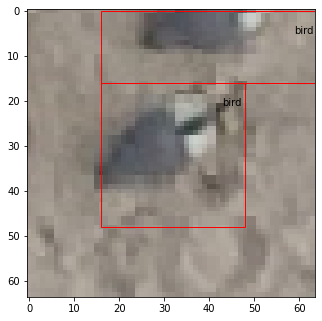

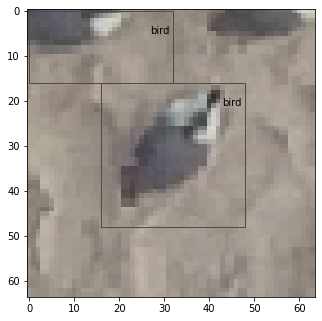

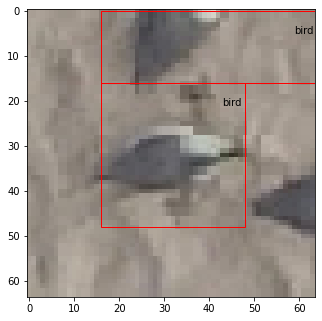

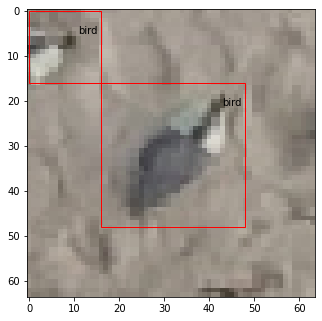

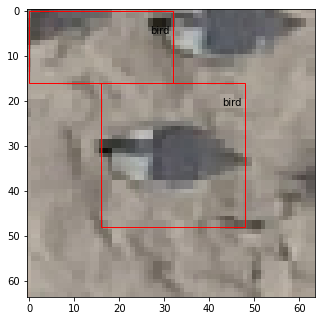

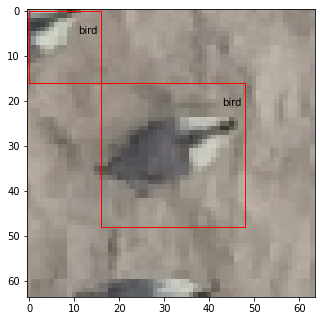

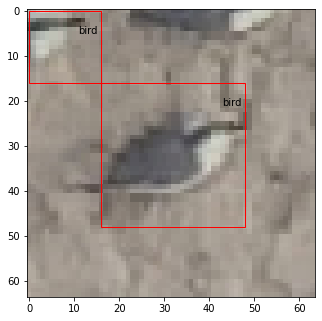

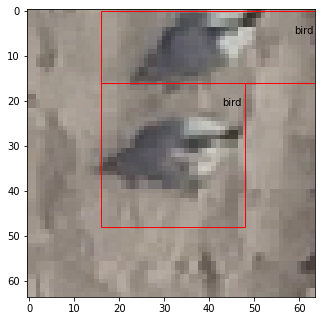

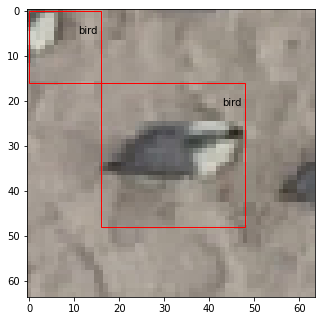

In [21]:
for name in img_names[:20]:
    #plot_bbox_plt(name)
    print(name)
    plot_bbox_truth_plt(name)